In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from torch.nn.modules.loss import BCELoss
from torch.utils.data import DataLoader

torch.manual_seed(18)

%matplotlib inline

In [ ]:
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from '/usr/local/lib/python3.7/dist-packages/torch/version.py'>
True


In [ ]:
def rotate_image(image, tar_image, deg=None):
    if deg is None:
        deg = np.random.randint(0,90)
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    tar_image = cv2.warpAffine(tar_image, M, (cols, rows))
    return image, tar_image

# def translation_image(image,x=None,y=None):
#     if x is None:
#         x = np.random.randint(0,50)
#     if y is None:
#         y = np.random.randint(0,50)
#     rows, cols= image.shape
#     M = np.float32([[1, 0, x], [0, 1, y]])
#     image = cv2.warpAffine(image, M, (cols, rows))
#     return

In [ ]:
success = True
videofile = "/content/animation.mp4"
vidcap = cv2.VideoCapture(videofile)
success, tar_image = vidcap.read()
# gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# (thresh, blackAndWhiteImage) = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
# blackAndWhiteImage = blackAndWhiteImage.astype(np.uint8)
# print(gray_img.shape)
# cv2_imshow(gray_img)
# values = []
# for i in range(200):
#   for j in range(200):
#     if int(gray_img[i,j]) > 0:
#       values.append(gray_img[i,j])
# print(values)
# cv2_imshow(blackAndWhiteImage)
# norm_img = cv2.normalize(blackAndWhiteImage, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# cv2_imshow(rotate_image(blackAndWhiteImage))
# cv2_imshow(translation_image(blackAndWhiteImage))


images = []
tar_images = []
while success:
    image = tar_image
    success, tar_image = vidcap.read()                                 # reads next frame
    
    if success:
      # Preprocessing
      img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)              # grayscale image
      tar_img = cv2.cvtColor(tar_image, cv2.COLOR_RGB2GRAY)              # grayscale image
      img = cv2.resize(img, (192,192))
      tar_img = cv2.resize(tar_img, (192,192))
      # (thresh, img) = cv2.threshold(img, 2, 255, cv2.THRESH_BINARY)  # black and white image
      # (thresh, tar_img) = cv2.threshold(tar_img, 2, 255, cv2.THRESH_BINARY)  # black and white image
      images.append(img)
      tar_images.append(tar_img)
      for _ in range(19):
        rot_img, tar_rot_img = rotate_image(img, tar_img)
        images.append(rot_img)
        tar_images.append(tar_rot_img)

images = np.array(images)
tar_images = np.array(tar_images)
print(images.shape)

(9980, 192, 192)


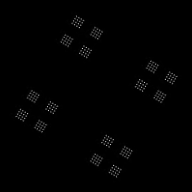

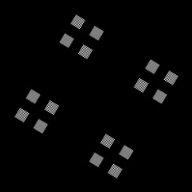

In [ ]:
idx = np.random.randint(9000)
img = images[idx]
tar_img = tar_images[idx]
cv2_imshow(img)
cv2_imshow(tar_img)

In [ ]:
images_tensor = torch.tensor(images)
tar_images_tensor = torch.tensor(tar_images)
rand_idx = torch.randperm(images_tensor.shape[0])
train_data = images_tensor[rand_idx[:9000]]
train_label = tar_images_tensor[rand_idx[:9000]]
test_data = images_tensor[rand_idx[9000:]]
test_label = tar_images_tensor[rand_idx[9000:]]
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

torch.Size([9000, 192, 192])
torch.Size([9000, 192, 192])
torch.Size([980, 192, 192])
torch.Size([980, 192, 192])


In [ ]:
# #decoder_block
# def decoder_block(in_channels, out_channels, scale, use_relu=True):
#     if use_relu:
#         block = nn.Sequential(
#             nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.PReLU(),
#         )
#     else:
#          block = nn.Sequential(
#             nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#         )
#     return block

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=2, kernel_size=3):
        super(ResNetBlock, self).__init__()
        self.residual_pass = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                                    stride = 1, padding = 1, padding_mode='replicate'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                                    stride = 1, padding = 1, padding_mode='replicate'), 
                               )
        self.identity_mapping = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1,
                                                    stride = 1),
                               )
        self.down_dimension = nn.Sequential(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=2,
                                                    stride = stride, padding = 0),
                               )                  
        self.RelU = nn.ReLU()
        
    def forward(self, x):
        residual = self.residual_pass(x)
        x = self.identity_mapping(x) 
        x += residual
        x =  self.RelU(x)
        x = self.down_dimension(x)
        return x

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.fc= nn.Linear(128*3*3, 1024)
        
        self.encoder = nn.Sequential(
            ResNetBlock(1, 16),
            ResNetBlock(16, 32),
            ResNetBlock(32, 64),
            ResNetBlock(64, 128),
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 256,  kernel_size=2, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128,  kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128,  kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64,  kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32,  kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16,  kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1,  kernel_size=4, stride=2, output_padding=0),

            # nn.ConvTranspose2d(512, 256, kernel_size=1),
            # decoder_block(256, 128, scale=1),
            # decoder_block(128, 64, scale=1),
            # decoder_block(64, 32, scale=5),
            # decoder_block(32, 1, scale=5, use_relu=False),
        )

    
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.fc(x.view(-1,128*3*3))
        x = x.unsqueeze(2)
        x = x.unsqueeze(3)
        # print(x.shape)
        x = self.decoder(x) 
        # print(x.shape) 
        x = torch.sigmoid(x)
        return x

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [ ]:
# model
model = AE()
print(countParameters(model), countParameters(model.encoder), countParameters(model.decoder))
model = model.cuda()

#test run
input = train_data[:32].unsqueeze(1)
input = input / 255
input = input.cuda()
print(input.shape, input.max(), input.min())
output = model(input) 
print(output.shape, output.max(), output.min())

3915473 1146208 1588593
torch.Size([32, 1, 192, 192]) tensor(0.8784, device='cuda:0') tensor(0., device='cuda:0')
torch.Size([32, 1, 192, 192]) tensor(0.5335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.5047, device='cuda:0', grad_fn=<MinBackward1>)


In [ ]:
# parameters
batch_size = 32
num_epochs = 1000

# optimizer
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.001)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

# criterion
criterion = nn.BCELoss()

# statistics
losses_train = []
losses_test = []

# for num_epochs
for epoch in range(num_epochs):
  
    # train mode
    model.train()
    
    # random mini-batches
    batch_train = torch.randperm(train_data.shape[0])
    batch_train = batch_train[(batch_train.numel() % batch_size):]
    batch_train = batch_train.view(-1, batch_size)
    
    # statistics
    running_loss = 0.0
    
    # for each mini-batch
    for i in range(batch_train.size(0)):
        
        # mini-batch
        input = train_data[batch_train[i], :].unsqueeze(1)
        input = input/255
        input = input.cuda()

        label = train_label[batch_train[i], :].unsqueeze(1)
        label = label/255
        label = label.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(input)
        # print(output.max(), output.min(), input.max(), input.min())
        # print(output.shape, input.shape)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
    
    running_loss /= batch_train.size(0)
    
    losses_train.append(running_loss)
    
    # update learning rate
    lr_scheduler.step()
    
    # output
    print('Epoch {} (train) -- loss: {:.8f}'.format(epoch, running_loss))
    
    # validate
    with torch.no_grad():
      
        # eval mode
        model.eval()

        # random mini-batches
        batch_valid = torch.randperm(test_data.shape[0])
        batch_valid = batch_valid[(batch_valid.numel() % batch_size):]
        batch_valid = batch_valid.view(-1, batch_size)

        # statistics
        running_loss = 0.0
        
        # for each mini-batch
        for i in range(batch_valid.size(0)):

            # mini-batch
            input = test_data[batch_valid[i], :].unsqueeze(1)
            input = input/255
            input = input.cuda()

            label = test_label[batch_valid[i], :].unsqueeze(1)
            label = label/255
            label = label.cuda()

            # forward
            output = model(input)
            loss = criterion(output, label)

            # statistics
            running_loss += loss.item()

        running_loss /= batch_valid.size(0)

        losses_test.append(running_loss)

        # output
        print('Epoch {} (test) -- loss: {:.8f}'.format(epoch, running_loss))
        input = input.squeeze(1).squeeze(1)[0].cpu().detach()*255
        # label = label.squeeze(1).squeeze(1)[0].cpu().detach()*255
        output = output.squeeze(1).squeeze(1)[0].cpu().detach()*255
        cv2_imshow(np.array(input,dtype=np.uint8))
        # cv2_imshow(np.array(label,dtype=np.uint8))
        cv2_imshow(np.array(output,dtype=np.uint8))
        
    # plt.close()
    # plt.subplot(1,2,1)
    # plt.plot(losses_train)
    # plt.title("traning loss")
    # plt.subplot(1,2,2)
    # plt.plot(losses_test)
    # plt.title("test loss")
    # plt.show()